# Gravitational waves detectability 

Even thou there is a huge number of gravitational waves sources, not all of them will be detected.
LIGO and VIRGO interferometers can detect gws in a range between 10-1000 Hz, in particular mergers between stellar mass black holes and neutron stars. 
The detectability can be influenced by the inclination and others parameters, modifying the **Signal-to-Noise ratio (SNR)** that we measure.

In [1]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
import h5py 
import pandas as pd
import seaborn as sns

In [2]:
file = h5py.File("sample_2e7_design_precessing_higherordermodes_3detectors.h5",'r+')  

The dataset contains simulated gravitational-wave signals from merging black holes. The threshold for the snr values, in LIGO experiment, is set to snr = 12. The resulting 0 - 1 labels are reported in the det attribute in the dataset.

In [29]:
print(file)
list(file.keys())

<HDF5 file "sample_2e7_design_precessing_higherordermodes_3detectors.h5" (mode r+)>


['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [30]:
# Let's work with less data
data= []

for idx, name in enumerate(list(file.keys())):
    data.append(file[name][0:1000])

data = pd.DataFrame(np.transpose(data))
data.columns = list(file.keys())
data


,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,det,iota,mtot,psi,q,ra,snr,z
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,0.0,1.809310,906.803562,1.286031,0.624780,-3.116784,0.822509,2.139659
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,0.0,0.820820,59.102112,0.934308,0.986650,1.360291,1.093237,2.438707
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,0.0,2.008206,44.602750,1.535520,0.286199,0.079973,1.305398,1.869461
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0.0,2.018398,534.378032,3.064086,0.538882,-1.780558,9.112974,0.428061
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,1.0,2.037363,573.821705,0.752211,0.846310,2.789289,17.525534,0.772609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.576429,-0.645197,0.106358,0.779329,0.480224,0.302788,-0.164741,0.0,1.784171,905.125763,2.367827,0.466528,-0.034750,0.993533,3.260640
996,-0.134131,0.205700,-0.107687,-0.046215,0.361217,-0.813627,-1.245679,0.0,2.560637,264.862843,1.422802,0.642199,2.816555,3.599715,3.244858
997,0.216536,-0.100850,0.299994,0.088451,0.136617,-0.121935,1.036102,1.0,0.415292,408.083801,3.102616,0.756706,-1.027694,20.986058,1.004410
998,0.274411,-0.156249,-0.064642,0.302982,0.366175,0.325817,0.919502,0.0,2.010860,588.336562,3.114282,0.692634,-2.490513,2.113289,2.580256


We will perform the analysis with two labels: first det (0,1) and then using snr(><12)

In [31]:
labels = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec','iota', 'mtot', 'psi', 'q', 'ra', 'z']

X = np.array((data[labels]))
det = np.array((data['det']))
snr = np.array((data['snr']))


Our goal is to train a classifier able to separate the detectable gw signals from the non detectable ones.

## Dimensionality reduction

### 1. PCA

Now, before training our classifier, we perform a dimensionality reduction on the data, so see if a lower dimension can improve the classification.

The usual machine-learning approach is to standardize the data such that each dimension has mean=0 and variance=1. We follow this approach using sklearn StandardScaler.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)
X_reduced = pca.fit_transform(X_scaled)

[0.09023658 0.08827026 0.08675158 0.08223845 0.08105495 0.07777018
 0.07701919 0.07562953 0.07346956 0.07025562 0.06930513 0.06638024
 0.06161873]


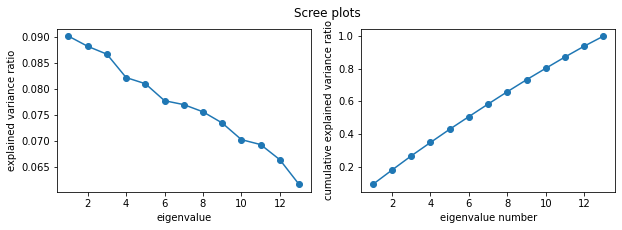

In [33]:
evals = pca.explained_variance_ratio_

print(evals)
n_components = 13
fig = plt.figure(figsize=(10, 3))


ax = fig.add_subplot(121)
ax.plot(np.arange(n_components)+1, evals)
ax.scatter(np.arange(n_components)+1, evals)
ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)
ax.plot(np.arange(n_components)+1, evals.cumsum())
ax.scatter(np.arange(n_components)+1, evals.cumsum())
ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.suptitle('Scree plots')

plt.show()

In [34]:
print(evals.cumsum())

[0.09023658 0.17850684 0.26525842 0.34749686 0.42855181 0.50632199
 0.58334118 0.65897072 0.73244028 0.8026959  0.87200103 0.93838127
 1.        ]


Looking at the scree plot we can conclude that it's not possible to perform a dimensionality reduction. We need 11 components to explain at least 87% of the variance. We cannot take just the firsts component. 

Maybe this is ascribable to the PCA, since it's a linear process. 
We try to resolve this doubt using **ISOMAP**, a non-linear method


### 2. ISOMAP

In [35]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components = 5)

X_isomap = embedding.fit_transform(X)
print(X_isomap.shape)


C:\Users\LEONARDO\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\LEONARDO\anaconda3\lib\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\LEONARDO\anaconda3\lib\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\LEONARDO\anaconda3\lib\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\LEONA

(1000, 5)


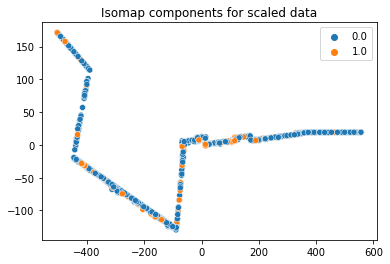

In [36]:
sns.scatterplot(x = X_isomap[:, 0], y = X_isomap[:,1], hue = det)
plt.title('Isomap components for scaled data');

After this inconclusive result we perform our analysis on the entire set of data.

## Decision Tree Classifier

### 1. target = det

We decide to use a **Decision Tree Classifier**, a non-parametric supervised learning method. Roughly speaking it's a hierarchical application of decision boundaries.

To obtain the optimal model parameters we perform a K-fold cross validation, in particular on the maximum depth of the three. We will use GridSearchCV to do that.


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
drange = np.arange(1,10)  

GS = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5, scoring = 'neg_root_mean_squared_error')
GS.fit(X, det)

optimal_depth = GS.best_params_['max_depth']
print('Optimal parameter: ', optimal_depth)
print(GS.best_estimator_)

Optimal parameter:  3
DecisionTreeClassifier(max_depth=3)


In [38]:
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, det, test_size=0.3, random_state=42)


We choose as splitting criteria "entropy".

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

dt = DecisionTreeClassifier(random_state=0, max_depth= optimal_depth, criterion='entropy') 
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

accuracy_dt_det = accuracy_score(y_test, y_pred)

print("Accuracy for DTC using det as target: %.3f" %accuracy_dt_det)

Accuracy for DTC using det as target: 0.947


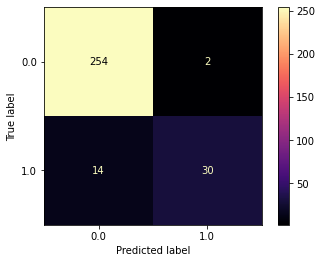

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=Conf_matrix, display_labels=dt.classes_)

disp.plot( cmap = 'magma')
plt.show()

We have an high accurancy but some confusion between objects with 0 as predicted label and 1 as true label.
We decide also to compute the **completness** and the **contamination**, defined as follow:

$$ 
{\rm completeness} = \frac{\rm true\ positives}{\rm true\ positives + false\ negatives} 
$$

$$  
{\rm contamination} = \frac{\rm false\ positives}{\rm true\ positives + false\ positives}
$$

In [41]:
# true negatives, false positives, false negatives, true positives
tn, fp, fn, tp = Conf_matrix.ravel() 

completeness_dt_det = tp/(tp+fn)
contamination_dt_det = fp/(tp+fp)

print("Completeness for DTC using det as target: %.3f" %completeness_dt_det)
print("Contamination for DTC using det as target: %.3f" %contamination_dt_det )

Completeness for DTC using det as target: 0.682
Contamination for DTC using det as target: 0.062


### 2. target = snr

We perform the same analysis but instead of using a classifier on det, we use a regressor on snr.

In [42]:
from sklearn.tree import DecisionTreeRegressor

rg = DecisionTreeRegressor()
drange = np.arange(1,10)  

GS = GridSearchCV(rg, param_grid={'max_depth': drange}, cv=5, scoring = 'neg_root_mean_squared_error')
GS.fit(X, snr)

optimal_depth = GS.best_params_['max_depth']
print('Optimal parameter: ', optimal_depth)
print(GS.best_estimator_)

Optimal parameter:  8
DecisionTreeRegressor(max_depth=8)


In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, snr, test_size=0.3, random_state=2)

dt = DecisionTreeRegressor(random_state=0, max_depth= optimal_depth, criterion = "squared_error") 
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("dt.predict gives snr predicted values, so I threshold the predictions")

y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)


accuracy_dt_snr = accuracy_score(y_test_class, y_pred_class)

print("Accuracy for DTR using snr: %.3f" %accuracy_dt_snr)

dt.predict gives snr predicted values, so I threshold the predictions
Accuracy for DTR using snr: 0.930


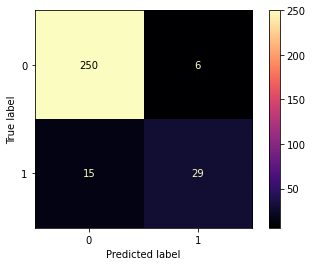

In [44]:
Conf_matrix = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=Conf_matrix)

disp.plot( cmap = 'magma')
plt.show()

In [45]:
# true negatives, false positives, false negatives, true positives
tn, fp, fn, tp = Conf_matrix.ravel() 

completeness_dt_snr = tp/(tp+fn)
contamination_dt_snr = fp/(tp+fp)

print("Completeness for DTR on snr: %.3f" %completeness_dt_snr)
print("Contamination for DTR on snr: %.3f" %contamination_dt_snr)

Completeness for DTR on snr: 0.659
Contamination for DTR on snr: 0.171


## Random Forest 

We can improve the Decision Tree with Bagging (bootstrap aggregation). In short, bagging averages the predictive results of a series of bootstrap samples of the original data.

We can do even more than that.

**Random forests** extend bagging by generating decision trees from the bootstrap samples. In addition to drawing random samples from our training set with replacement, we may also draw random subsets of features for training the individual trees.


### 1. target = det

We perform a K-fold cross validation to determine both the maximum depth and the number od the trees.

In [46]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
drange = np.arange(1,10)  

GS = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5, scoring = 'neg_root_mean_squared_error')
GS.fit(X, det)

optimal_depth = GS.best_params_['max_depth']
print('Optimal depth: ', optimal_depth)
print(GS.best_estimator_)

ntrees = np.arange(1,20) 
GS = GridSearchCV(clf, param_grid={'n_estimators': ntrees}, cv=5, scoring = 'neg_root_mean_squared_error')
GS.fit(X, det)

optimal_trees = GS.best_params_['n_estimators']
print('Optimal number of trees: ', optimal_trees)
print(GS.best_estimator_)

Optimal depth:  7
RandomForestClassifier(max_depth=7)
Optimal number of trees:  9
RandomForestClassifier(n_estimators=9)


In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, det, test_size=0.3, random_state=8)

In [48]:
rf = RandomForestClassifier(random_state=0, max_depth= optimal_depth, n_estimators = optimal_trees , criterion='entropy') 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy_rf_det = accuracy_score(y_test, y_pred)

print("Accuracy for RF using det as target: %.3f" %accuracy_rf_det)

Accuracy for RF using det as target: 0.920


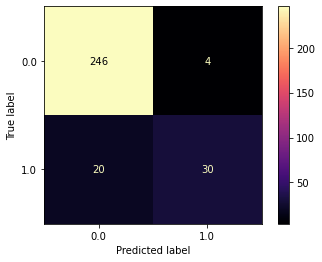

In [49]:
Conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=Conf_matrix, display_labels=rf.classes_)

disp.plot( cmap = 'magma')
plt.show()

In [50]:
# true negatives, false positives, false negatives, true positives
tn, fp, fn, tp = Conf_matrix.ravel() 

completeness_rf_det = tp/(tp+fn)
contamination_rf_det = fp/(tp+fp)

print("Completeness for RF using det as target: %.3f" %completeness_rf_det)
print("Contamination for RF using det as target: %.3f" %contamination_rf_det )

Completeness for RF using det as target: 0.600
Contamination for RF using det as target: 0.118


### 2. target = snr

In [74]:
from sklearn.ensemble import RandomForestRegressor

rg = RandomForestRegressor()
drange = np.arange(1,10)  

GS = GridSearchCV(rg, param_grid={'max_depth': drange}, cv=5, scoring = 'neg_root_mean_squared_error')
GS.fit(X, snr)

optimal_depth = GS.best_params_['max_depth']
print('Optimal depth: ', optimal_depth)
print(GS.best_estimator_)

ntrees = np.arange(1,20) 
GS = GridSearchCV(clf, param_grid={'n_estimators': ntrees}, cv=5, scoring = 'neg_root_mean_squared_error')
GS.fit(X, det)

optimal_trees = GS.best_params_['n_estimators']
print('Optimal number of trees: ', optimal_trees)
print(GS.best_estimator_)

Optimal depth:  6
RandomForestRegressor(max_depth=6)
Optimal number of trees:  8
RandomForestClassifier(n_estimators=8)


In [78]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, snr, test_size=0.3, random_state=3)

rf = RandomForestRegressor(random_state=0, max_depth= optimal_depth , n_estimators = optimal_trees, criterion = "absolute_error") 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)



y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)

accuracy_rf_snr = accuracy_score(y_test_class, y_pred_class)

print("Accuracy for RF using snr: %.3f" %accuracy_rf_snr)

Accuracy for RF using snr: 0.930


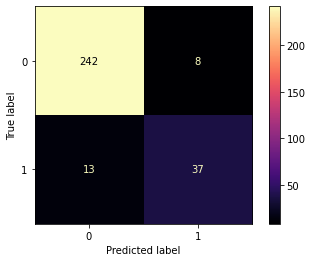

In [79]:
Conf_matrix = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=Conf_matrix)

disp.plot( cmap = 'magma')
plt.show()

In [80]:
# true negatives, false positives, false negatives, true positives
tn, fp, fn, tp = Conf_matrix.ravel() 

completeness_rf_snr = tp/(tp+fn)
contamination_rf_snr = fp/(tp+fp)

print("Completeness for RF using snr: %.3f" %completeness_rf_snr)
print("Contamination for RF using using snr: %.3f" %contamination_rf_snr)

Completeness for RF using snr: 0.740
Contamination for RF using using snr: 0.178


## Summary results

In [81]:
print("--- Accuracy ---")
print("Accuracy for DTC using det as target: %.3f" %accuracy_dt_det)
print("Accuracy for DTR using snr: %.3f" %accuracy_dt_snr)
print("Accuracy for RF using det as target: %.3f" %accuracy_rf_det)
print("Accuracy for RF using snr: %.3f" %accuracy_rf_snr)

print("\n")
print("--- Completeness ---")
print("Completeness for DTC using det as target: %.3f" %completeness_dt_det)
print("Completeness for DTR on snr: %.3f" %completeness_dt_snr)
print("Completeness for RF using det as target: %.3f" %completeness_rf_det)
print("Completeness for RF using snr: %.3f" %completeness_rf_snr)

print("\n")
print("--- Contamination ---")

print("Contamination for DTC using det as target: %.3f" %contamination_dt_det)
print("Contamination for DTR on snr: %.3f" %contamination_dt_snr)
print("Contamination for RF using det as target: %.3f" %contamination_rf_det)
print("Contamination for RF using using snr: %.3f" %contamination_rf_snr)

--- Accuracy ---
Accuracy for DTC using det as target: 0.947
Accuracy for DTR using snr: 0.930
Accuracy for RF using det as target: 0.920
Accuracy for RF using snr: 0.930


--- Completeness ---
Completeness for DTC using det as target: 0.682
Completeness for DTR on snr: 0.659
Completeness for RF using det as target: 0.600
Completeness for RF using snr: 0.740


--- Contamination ---
Contamination for DTC using det as target: 0.062
Contamination for DTR on snr: 0.171
Contamination for RF using det as target: 0.118
Contamination for RF using using snr: 0.178
